# Fitting ellipse: approach 1

This method takes the 2D emission distribution (integrated intensity or in a velocity channel) and fits a full 2D ellipse model to the observed data.
To fit the 2D emission distribution, it assumes a normal intensity distribution as a function of the distance from the ellipse. This has the advantage that it not only provides an estimate for the minor and major axis of the ellipse, it also gives an estimate of the width of the ellipse.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits

from scipy.optimize import curve_fit

In [2]:
#### User input ####

## file name to be used
file_name = "CYGNUSX_CII_merged.fits"

## velocity channel to be fitted
vel = -2.  

## minimal intensity to be considered in the fitting procedure (ideally S/N based)
T_min = 3.

## assumed distance to the region
dist = 1400. ## pc

## the coordinates to cut the region of interest around the ellipse to be fitted
xmin, xmax = 200, 450
ymin, ymax = 30, 300

In [3]:
## open the fits file and read the data & header
hdu = pyfits.open(file_name)
hdu.info()
data = hdu[0].data
header = hdu[0].header

Filename: CYGNUSX_CII_merged.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (534, 784, 400)   float64   


In [4]:
## Use the velocity channel and header information to determin the z index for the slice to be extracted from the data cube
slice_ind = int(header["CRPIX3"] + (vel - 0.001*header["CRVAL3"]) / (0.001*header["CDELT3"]))

## calculate the pixel size in parsec (assumes pixel size is equal in x and y direction)
pix_size = dist * header["CDELT2"] * np.pi / 180.
print(pix_size)

0.023755870643071678


In [5]:
## extract the velocity slice
data_2d = data[slice_ind, ymin:ymax, xmin:xmax]

## remove low-intensity data
data_2d[data_2d < T_min] = np.nan

## get the shape of the data (will be used later for the initial guess for the fitting)
data_shape = data_2d.shape

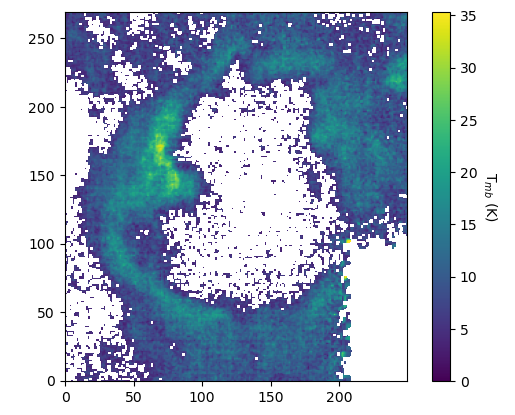

In [6]:
## plot the data that will be fitted
fig, ax = plt.subplots()
ax1 = fig.add_subplot(111)
im = ax1.imshow(data_2d, origin='lower', vmin=0.)

cbar = fig.colorbar(im)# cax=cbaraxis)
cbar.set_label('T$_{mb}$ (K)', labelpad=15.,rotation=270.)

ax.axis('off')
plt.show()

In [7]:
## create a numpy 2D array with the indices for the 2D velocity slice
inds = np.indices(data_2d.shape)


## ravel the indices and intensity data for fitting
xs_orig = inds[1].ravel() ## because inds: [[ys], [xs]]
ys_orig = inds[0].ravel()
zs = data_2d.ravel()

## remove all nans from the data
xs = xs_orig[~np.isnan(zs)]
ys = ys_orig[~np.isnan(zs)]
zs = zs[~np.isnan(zs)]

In [8]:
## function to fit, i.e. an ellipse with a random angle theta
## - centered on (cx, cy), with major and minor axes (a, b)
## - with a width (w) and peak intensity (Tpeak)
## returns the predicted intensity for each pixel X (tupple containing (x,y))
def ellipse(X, cx, cy, a, b, w, Tpeak, theta):
    ## read pixel coordinates input
    y_pix, x_pix = X

    ## perform a translation followed by a rotation of the pixel coordinates to the reference frame of the ellipse
    new_x = (x_pix - cx)*np.cos(theta) - (y_pix - cy)*np.sin(theta)
    new_y = (x_pix - cx)*np.sin(theta) + (y_pix - cy)*np.cos(theta)

    ## distance between pixel and center of the ellipse
    d1 = np.sqrt(new_x**2 + new_y**2)

    ## Find the intersection with the ellipse
    m = new_y / (new_x + 0.01) ## + 0.01 to avoid division by zero
    cte = a**(-2) + (m/b)**2

    ## get x location of the intersection with the ellipse
    ## The -2* includes a conditional statement to handle the situation when new_x < 0
    x_el = np.sqrt(1./cte) - 2.*(new_x < 0)*np.sqrt(1./cte)

    ## avoid small effects leading to errors in the square root calculation
    x_el[np.abs(x_el) >= a] = a

    ## get y location of the intersection with the ellipse
    ## The -2* includes a conditional statement to handle the situation when new_y < 0
    y_el = b*np.sqrt(1. - (x_el/a)**2) - 2.*(new_y < 0)*b*np.sqrt(1. - (x_el/a)**2)

    ## distance to the intersection with the ellipse
    d2 = np.sqrt((x_el)**2 + (y_el)**2)

    ## distance between the pixel point and the location on the ellipse
    d = np.abs(d1-d2)
    
    ## return the intensity at the location
    Treturn = Tpeak * np.exp(-(d/w)**2)
    
    return Treturn 

In [9]:
## function to fit, i.e. an ellipse
## - centered on (cx, cy), with major and minor axes (a, b)
## - with a width (w) and peak intensity (Tpeak)
## returns the predicted intensity for each pixel X (tupple containing (x,y))
def ellipse_fixed(X, cx, cy, a, b, w, Tpeak):
    ## read pixel coordinates input
    y_pix, x_pix = X
    
    ## distance between pixel and center of the ellipse
    d1 = np.sqrt((x_pix - cx)**2 + (y_pix - cy)**2)
    
    ## Find the intersection with the ellipse
    m = (y_pix - cy) / (x_pix - cx + 0.01) ## + 0.01 to avoid division by zero
    cte = a**(-2) + (m/b)**2
    
    ## get x location of the intersection with the ellipse
    ## The -2* includes a conditional statement to handle the situation when x_pix < cx
    x_el = cx + np.sqrt(1/cte) - 2.*(x_pix < cx)*np.sqrt(1/cte)
    
    ## avoid small effects leading to errors in the square root calculation
    x_el[np.abs(x_el-cx) >= a] = cx + a
    
    ## get y location of the intersection with the ellipse
    ## The -2* includes a conditional statement to handle the situation when y_pix < cy
    y_el = cy + b*np.sqrt(1. - ((x_el - cx)/a)**2) - 2.*(y_pix < cy)*b*np.sqrt(1. - ((x_el - cx)/a)**2)
    
    ## distance to the intersection with the ellipse
    d2 = np.sqrt((x_el - cx)**2 + (y_el - cy)**2)
    
    
    ## distance between the pixel point and the location on the ellipse
    d = np.abs(d1-d2)
    
    ## return the intensity at the location
    Treturn = Tpeak * np.exp(-(d/w)**2)
    
    return Treturn 

In [10]:
## generate an initial guess to fit the data
#init_guess = [0.5*data_shape[1], 0.5*data_shape[0], 0.35*data_shape[1], 0.35*data_shape[0], 0.05*0.5*(data_shape[1] + data_shape[0]), 0.5*np.nanmax(zs)]
init_guess_theta = [0.5*data_shape[1], 0.5*data_shape[0], 0.35*data_shape[1], 0.35*data_shape[0], 0.05*0.5*(data_shape[1] + data_shape[0]), 0.5*np.nanmax(zs), 0.]

## perform the fitting with curve_fit
#popt, pcov = curve_fit(ellipse_fixed, (ys, xs), zs, p0 = init_guess)
popt, pcov = curve_fit(ellipse, (ys, xs), zs, p0 = init_guess_theta)


In [16]:
## print the results
print("The central position of the ellipse is: ({cx},{cy})".format(cx = round(popt[0], 1), cy = round(popt[1], 1)))
print("The major and minor axis of the ellipse are: {a} pc & {b} pc)".format(a = round(popt[2]*pix_size, 1), b = round(popt[3]*pix_size, 1)))
print("The width of the ellipse is: {w} pc".format(w = round(popt[4]*pix_size, 1)))
print("The peak intensity at the crest of the ellipse is: {T} K".format(T = round(popt[5], 1)))
print("The angle of the ellipse is: {th}".format(th = popt[6]*180./np.pi))

The central position of the ellipse is: (143.2,129.6)
The major and minor axis of the ellipse are: 2.1 pc & 2.7 pc)
The width of the ellipse is: 1.5 pc
The peak intensity at the crest of the ellipse is: 11.4 K
The angle of the ellipse is: 2.8271395223235816


In [12]:
## generate the fitted ellipse model
#fit_result = ellipse_fixed(inds, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5])
fit_result = ellipse(inds, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], popt[6])

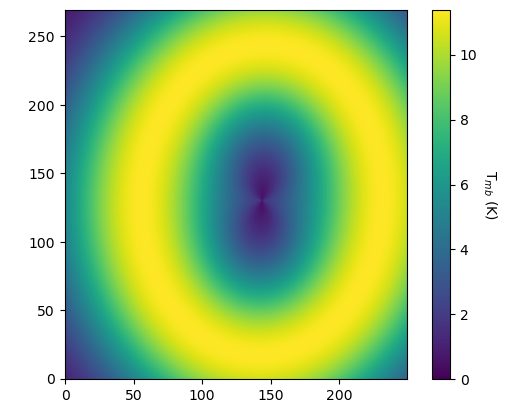

In [13]:
## plot the fitted ellipse model
fig, ax = plt.subplots()
ax1 = fig.add_subplot(111)
im = ax1.imshow(fit_result, origin='lower', vmin=0.)

cbar = fig.colorbar(im)
cbar.set_label('T$_{mb}$ (K)', labelpad=15.,rotation=270.)

ax.axis('off')
plt.show()

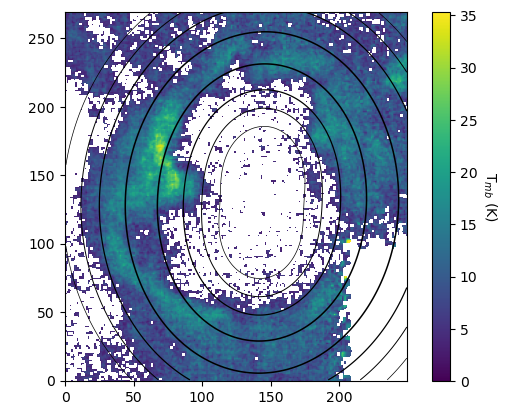

In [14]:
## plot the observations with the fitted ellipse model using contours
fig, ax = plt.subplots()
ax1 = fig.add_subplot(111)
im = ax1.imshow(data_2d, origin='lower', vmin=0.)

ctrs = ax1.contour(fit_result, levels = [5., 7., 9., 11.], linewidths = [0.5, 0.7, 0.9, 1.1], colors = 'k', origin = 'lower')

cbar = fig.colorbar(im)
cbar.set_label('T$_{mb}$ (K)', labelpad=15.,rotation=270.)

ax.axis('off')
plt.show()

The fitting works will at v < -3 km/s where the ring is clear. At higher velocities, where the ring is not so clear, the fitting does not work well.
